**ARIMA MODEL**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
# Load the dataset
data = pd.read_csv('/kaggle/input/netflix-stock-price-prediction/NFLX.csv', parse_dates=True, index_col='Date')
data = data['Close'].dropna()

In [4]:
# Train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [13]:
# Fit ARIMA model
model = ARIMA(train, order=(4, 1, 0)) 
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
# Make predictions
forecast = model_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [15]:
# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
print(f"ARIMA RMSE: {rmse_arima}")

ARIMA RMSE: 70.68790418035384


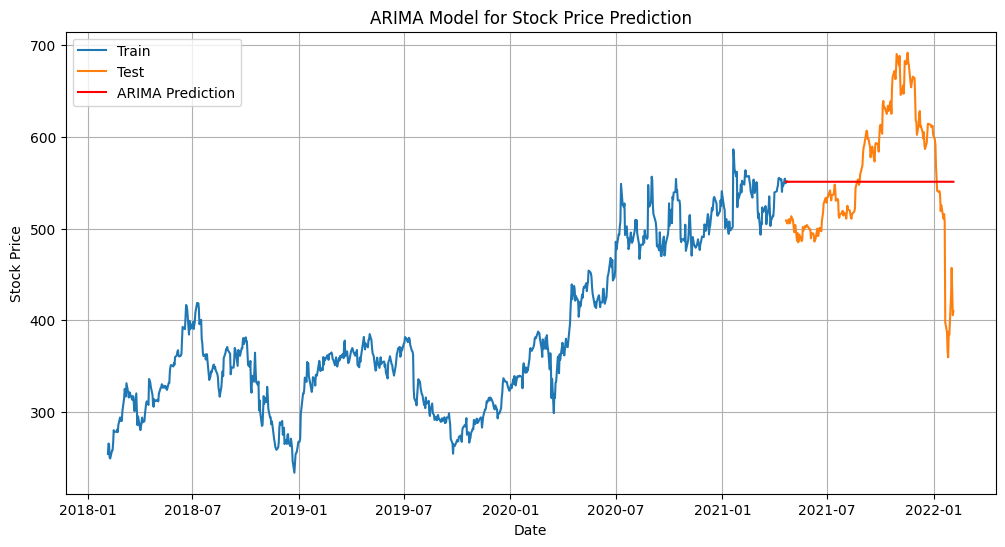

In [16]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Prediction', color='red')
plt.legend()
plt.title('ARIMA Model for Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

**LSTM Model**

In [17]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

2025-10-03 03:48:47.455591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759463327.673829      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759463327.740938      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

In [19]:
# Create sliding window of data
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

In [20]:
# Train-test split for LSTM
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

2025-10-03 03:50:15.950636: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Compile and train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.0619 - val_loss: 0.0270
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0023 - val_loss: 0.0076
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0019 - val_loss: 0.0088
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

In [24]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


In [25]:
# Inverse scaling for true values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
# Calculate RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f"LSTM RMSE: {rmse_lstm}")

LSTM RMSE: 15.259176203079432


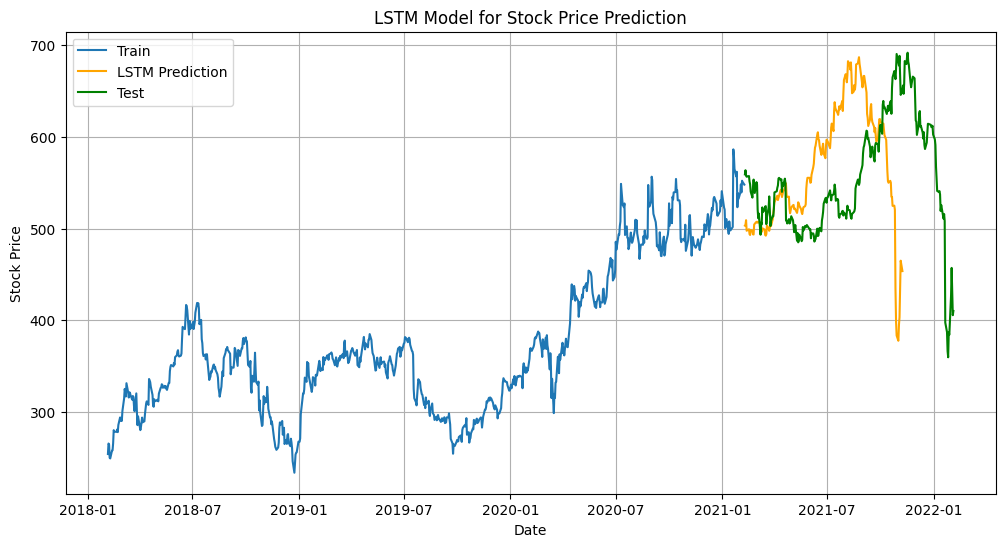

In [28]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(data.index[:train_size], data[:train_size], label='Train') 
plt.plot(data.index[train_size:train_size+len(predictions)], predictions, label='LSTM Prediction', color='orange')  # Predictions
plt.plot(data.index[train_size:], data[train_size:], label='Test', color='green')
plt.legend()
plt.title('LSTM Model for Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()